# STATISTICAL ANALYSIS
### Cryptocurrency vs Equity Markets
#### MANAV AGARWAL
This notebook implements advanced statistical methods for comparing machine learning
performance between cryptocurrency and equity markets, including deflated Sharpe ratios,
probabilistic performance metrics, and robust hypothesis testing.

### Data Flow:
- Input: `notebooks/01_comprehensive_results.pkl` from notebook 01
- Output: `notebooks/02_statistical_results.pkl` for downstream analysis

In [1]:
# Import
import sys
import os
os.chdir('C:/Users/manav')
sys.path.append('src')

import pandas as pd
import numpy as np 
from tqdm import tqdm  # Progress bars
from joblib import Parallel, delayed  # Parallel processing
import multiprocessing as mp
from functools import lru_cache 
try:
    import cupy as cp
    HAS_GPU = True
    print("CuPy (GPU) available for acceleration")
except ImportError:
    HAS_GPU = False
    cp = None  # Don't alias to np
    print("CuPy not available, using NumPy (CPU) fallback")

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import jarque_bera, shapiro, anderson, kstest
from scipy.stats import skew, kurtosis, norm
from scipy.stats.mstats import normaltest
import warnings
warnings.filterwarnings('ignore')

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera as jb_test
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
import pickle
import json

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams.update({
    'figure.dpi': 150,
    'figure.figsize': (14, 8),
    'font.size': 11,
    'axes.titleweight': 'bold',
    'axes.labelweight': 'bold',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 2
})

# Set number of parallel jobs
N_JOBS = mp.cpu_count() - 1  # Leave one CPU free
print(f"[OK] Libraries loaded successfully")
print(f"[INFO] Using {N_JOBS} parallel workers")

CuPy (GPU) available for acceleration
[OK] Libraries loaded successfully
[INFO] Using 31 parallel workers


### 1. Load Data from Previous Notebook

In [2]:
# Load results from notebook 01
print("Loading data from notebook 01...")
try:
    with open('notebooks/01_comprehensive_results.pkl', 'rb') as f:
        nb01_results = pickle.load(f)
    print("Successfully loaded notebook 01 results")
    print(f"Keys available: {list(nb01_results.keys())}")
    all_data = nb01_results.get('all_data', {})
    crypto_symbols = nb01_results.get('crypto_symbols', [])
    equity_symbols = nb01_results.get('equity_symbols', [])
    metadata = nb01_results.get('metadata', {})
    engineered_data = {}
    model_results = {}
    config = metadata
    
    crypto_symbols = metadata.get('crypto_symbols', ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD'])
    equity_symbols = metadata.get('equity_symbols', ['SPY', 'QQQ', 'IWM'])
    print(f"\nCrypto symbols loaded: {crypto_symbols}")
    print(f"Equity symbols configured: {equity_symbols}")
    available_crypto = [s for s in crypto_symbols if s in all_data]
    available_equity = [s for s in equity_symbols if s in all_data]
    print(f"\nActually available:")
    print(f"  Crypto: {available_crypto} ({len(available_crypto)}/{len(crypto_symbols)})")
    print(f"  Equity: {available_equity} ({len(available_equity)}/{len(equity_symbols)})")
   
    for symbol in available_crypto:
        if symbol in all_data:
            df = all_data[symbol]
            print(f"\n{symbol}:")
            print(f"  Records: {len(df)}")
            print(f"  Date range: {df.index.min()} to {df.index.max()}")
            print(f"  Columns: {list(df.columns)[:10]}")  # Show first 10 columns

    for symbol in available_equity: 
        if symbol in all_data:
            df = all_data[symbol]
            print(f"\n{symbol}:")
            print(f"  Records: {len(df)}")
            print(f"  Date range: {df.index.min()} to {df.index.max()}")
            print(f"  Columns: {list(df.columns)[:10]}")  # Show first 10 columns
        
except FileNotFoundError:
    print("Could not find Pickle file")
    raise

Loading data from notebook 01...
Successfully loaded notebook 01 results
Keys available: ['all_data', 'engineered_data', 'walk_forward_splits', 'model_results', 'statistical_results', 'config', 'timestamp']

Crypto symbols loaded: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD']
Equity symbols configured: ['SPY', 'QQQ', 'IWM']

Actually available:
  Crypto: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD'] (5/5)
  Equity: ['SPY', 'QQQ', 'IWM'] (3/3)

BTCUSD:
  Records: 1359129
  Date range: 2023-01-01 00:00:00 to 2025-08-01 23:59:00
  Columns: ['ticker', 'volume', 'open', 'close', 'high', 'low', 'window_start', 'transactions']

ETHUSD:
  Records: 1358218
  Date range: 2023-01-01 00:00:00 to 2025-08-01 23:59:00
  Columns: ['ticker', 'volume', 'open', 'close', 'high', 'low', 'window_start', 'transactions']

SOLUSD:
  Records: 1354459
  Date range: 2023-01-01 00:00:00 to 2025-08-01 23:59:00
  Columns: ['ticker', 'volume', 'open', 'close', 'high', 'low', 'window_start', 'transactions']


## 2. Data Quality Assessment and Preparation

In [3]:
# Prepare data for analysis
analysis_data = {}
# Process available symbols
all_symbols = available_crypto + available_equity

print("Preparing data for statistical analysis...\n")

for symbol in all_symbols:
    if symbol in all_data:
        df = all_data[symbol].copy()
        
        # Calculate returns if not present
        if 'returns' not in df.columns:
            df['returns'] = df['close'].pct_change()
        
        # Calculate log returns
        if 'log_returns' not in df.columns:
            df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
        
        df = df.dropna()
        
        analysis_data[symbol] = df
        
        # Basic statistics
        print(f"{symbol}:")
        print(f"  Shape: {df.shape}")
        print(f"  Missing values: {df.isnull().sum().sum()}")
        print(f"  Return mean: {df['returns'].mean():.6f}")
        print(f"  Return std: {df['returns'].std():.6f}")
        print(f"  Skewness: {skew(df['returns']):.3f}")
        print(f"  Kurtosis: {kurtosis(df['returns']):.3f}")
        print()

print(f"\n[OK] Prepared {len(analysis_data)} datasets for analysis")

Preparing data for statistical analysis...

BTCUSD:
  Shape: (1359128, 10)
  Missing values: 0
  Return mean: 0.000002
  Return std: 0.000810
  Skewness: -0.291
  Kurtosis: 44.698

ETHUSD:
  Shape: (1358217, 10)
  Missing values: 0
  Return mean: 0.000001
  Return std: 0.000925
  Skewness: -2.114
  Kurtosis: 293.596

SOLUSD:
  Shape: (1354458, 10)
  Missing values: 0
  Return mean: 0.000003
  Return std: 0.001401
  Skewness: 1.755
  Kurtosis: 301.689

XRPUSD:
  Shape: (1311370, 10)
  Missing values: 0
  Return mean: 0.000003
  Return std: 0.001355
  Skewness: -0.663
  Kurtosis: 270.586

ADAUSD:
  Shape: (1347194, 10)
  Missing values: 0
  Return mean: 0.000002
  Return std: 0.001416
  Skewness: 0.806
  Kurtosis: 542.085

SPY:
  Shape: (77638, 10)
  Missing values: 0
  Return mean: 0.000003
  Return std: 0.000608
  Skewness: 135.796
  Kurtosis: 29773.755

QQQ:
  Shape: (78492, 10)
  Missing values: 0
  Return mean: 0.000006
  Return std: 0.000944
  Skewness: 171.214
  Kurtosis: 40704.72

### 3. Distribution Analysis and Normality Testing

    Comprehensive distribution analysis for returns
    
    Formulas:
    - Skewness: E[(X - μ)³] / σ³
    - Kurtosis: E[(X - μ)⁴] / σ⁴ 
    - Jarque-Bera: n/6 * (S² + (K-3)²/4) where S=skewness, K=kurtosis
    - Sharpe Ratio: (E[R] - Rf) / σ, we assume Rf = 0

In [4]:
def analyze_distribution(data, symbol, returns_col='returns'):
    try:
        returns = data[returns_col].dropna()    
        returns_np = returns.values if hasattr(returns, 'values') else np.array(returns)
        
        # Calculate moments
        mean_return = float(np.mean(returns_np))
        std_return = float(np.std(returns_np, ddof=1))
        moments = {
            'mean': mean_return,
            'std': std_return,
            'skewness': float(skew(returns_np, bias=False)),  # Unbiased estimator
            'kurtosis': float(kurtosis(returns_np, bias=False)),  # Unbiased estimator
            'excess_kurtosis': float(kurtosis(returns_np, fisher=True, bias=False))  # Excess kurtosis (K - 3)
        }
        
        # Normality tests
        jb_stat, jb_pval = jarque_bera(returns_np)
        shapiro_stat, shapiro_pval = shapiro(returns_np) if len(returns_np) < 5000 else (np.nan, np.nan)
        ks_stat, ks_pval = kstest(returns_np, 'norm', args=(mean_return, std_return))
        
        # ARCH effect test
        try:
            arch_test = het_arch(returns_np, nlags=10)
            has_arch = arch_test[1] < 0.05 
        except:
            has_arch = None
        
        #  Dickey-Fuller test for stationarity
        try:
            adf_result = adfuller(returns_np, autolag='AIC')
            adf_stat = adf_result[0]
            adf_pval = adf_result[1]
            is_stationary = adf_pval < 0.05
        except:
            adf_stat, adf_pval, is_stationary = None, None, None
        
        results = {
            'symbol': symbol,
            'moments': moments,
            'normality': {
                'jarque_bera': {'statistic': jb_stat, 'p_value': jb_pval},
                'shapiro': {'statistic': shapiro_stat, 'p_value': shapiro_pval},
                'ks_test': {'statistic': ks_stat, 'p_value': ks_pval}
            },
            'arch_effects': has_arch,
            'stationarity': {
                'adf_statistic': adf_stat,
                'p_value': adf_pval,
                'is_stationary': is_stationary
            }
        }
        
        return results
    except Exception as e:
        print(f"Error analyzing {symbol}: {str(e)}")
        return None

print("DISTRIBUTION ANALYSIS RESULTS")
print("="*80)
print(f"Processing {len(all_symbols)} symbols\n")

distribution_results = {}

# Process each symbol individually with progress tracking
for i, symbol in enumerate(all_symbols, 1):
    if symbol in analysis_data:
        print(f"[{i}/{len(all_symbols)}] Processing {symbol}...", end=' ')
        result = analyze_distribution(analysis_data[symbol], symbol)
        if result:
            distribution_results[symbol] = result
            print("OK")
        else:
            print("FAIL")
    else:
        print(f"[{i}/{len(all_symbols)}] Skipping {symbol} (no data)")

# Display results
print("RESULTS SUMMARY")
print("="*80)

for symbol in all_symbols:
    if symbol in distribution_results:
        results = distribution_results[symbol]
        print(f"\n{symbol}:")
        print(f"  Moments:")
        for k, v in results['moments'].items():
            print(f"    {k}: {v:.6f}")
        print(f"  Normality (p-values):")
        for test, vals in results['normality'].items():
            if vals['p_value'] is not None and not np.isnan(vals['p_value']):
                print(f"    {test}: {vals['p_value']:.6f} {'[NORMAL]' if vals['p_value'] > 0.05 else '[NON-NORMAL]'}")
        print(f"  ARCH effects: {'Yes' if results['arch_effects'] else 'No' if results['arch_effects'] is not None else 'N/A'}")
        if results['stationarity']['is_stationary'] is not None:
            print(f"  Stationary: {'Yes' if results['stationarity']['is_stationary'] else 'No'}")

print(f"\n[OK] Distribution analysis complete for {len(distribution_results)} symbols")

DISTRIBUTION ANALYSIS RESULTS
Processing 8 symbols sequentially

[1/8] Processing BTCUSD... ✓
[2/8] Processing ETHUSD... ✓
[3/8] Processing SOLUSD... ✓
[4/8] Processing XRPUSD... ✓
[5/8] Processing ADAUSD... ✓
[6/8] Processing SPY... ✓
[7/8] Processing QQQ... ✓
[8/8] Processing IWM... ✓

RESULTS SUMMARY

BTCUSD:
  Moments:
    mean: 0.000002
    std: 0.000810
    skewness: -0.291128
    kurtosis: 44.698513
    excess_kurtosis: 44.698513
  Normality (p-values):
    jarque_bera: 0.000000 [NON-NORMAL]
    ks_test: 0.000000 [NON-NORMAL]
  ARCH effects: Yes

ETHUSD:
  Moments:
    mean: 0.000001
    std: 0.000925
    skewness: -2.114286
    kurtosis: 293.597271
    excess_kurtosis: 293.597271
  Normality (p-values):
    jarque_bera: 0.000000 [NON-NORMAL]
    ks_test: 0.000000 [NON-NORMAL]
  ARCH effects: Yes

SOLUSD:
  Moments:
    mean: 0.000003
    std: 0.001401
    skewness: 1.754651
    kurtosis: 301.690421
    excess_kurtosis: 301.690421
  Normality (p-values):
    jarque_bera: 0.00000

## 4. Comprehensive Return Distribution Visualization

DISTRIBUTION VISUALIZATION

Distribution Statistics Summary:

BTCUSD:
  Count: 1359128
  Mean: 0.000002
  Std: 0.000810
  Skewness: -0.291
  Kurtosis: 44.698
  Min: -0.036938
  25%: -0.000286
  50% (median): 0.000000
  75%: 0.000290
  Max: 0.036828

ETHUSD:
  Count: 1358217
  Mean: 0.000001
  Std: 0.000925
  Skewness: -2.114
  Kurtosis: 293.596
  Min: -0.102181
  25%: -0.000351
  50% (median): 0.000000
  75%: 0.000353
  Max: 0.054582

SOLUSD:
  Count: 1354458
  Mean: 0.000003
  Std: 0.001401
  Skewness: 1.755
  Kurtosis: 301.689
  Min: -0.059722
  25%: -0.000602
  50% (median): 0.000000
  75%: 0.000601
  Max: 0.190239

XRPUSD:
  Count: 1311370
  Mean: 0.000003
  Std: 0.001355
  Skewness: -0.663
  Kurtosis: 270.586
  Min: -0.092770
  25%: -0.000485
  50% (median): 0.000000
  75%: 0.000490
  Max: 0.113176

ADAUSD:
  Count: 1347194
  Mean: 0.000002
  Std: 0.001416
  Skewness: 0.806
  Kurtosis: 542.085
  Min: -0.138424
  25%: -0.000560
  50% (median): 0.000000
  75%: 0.000562
  Max: 0.1698

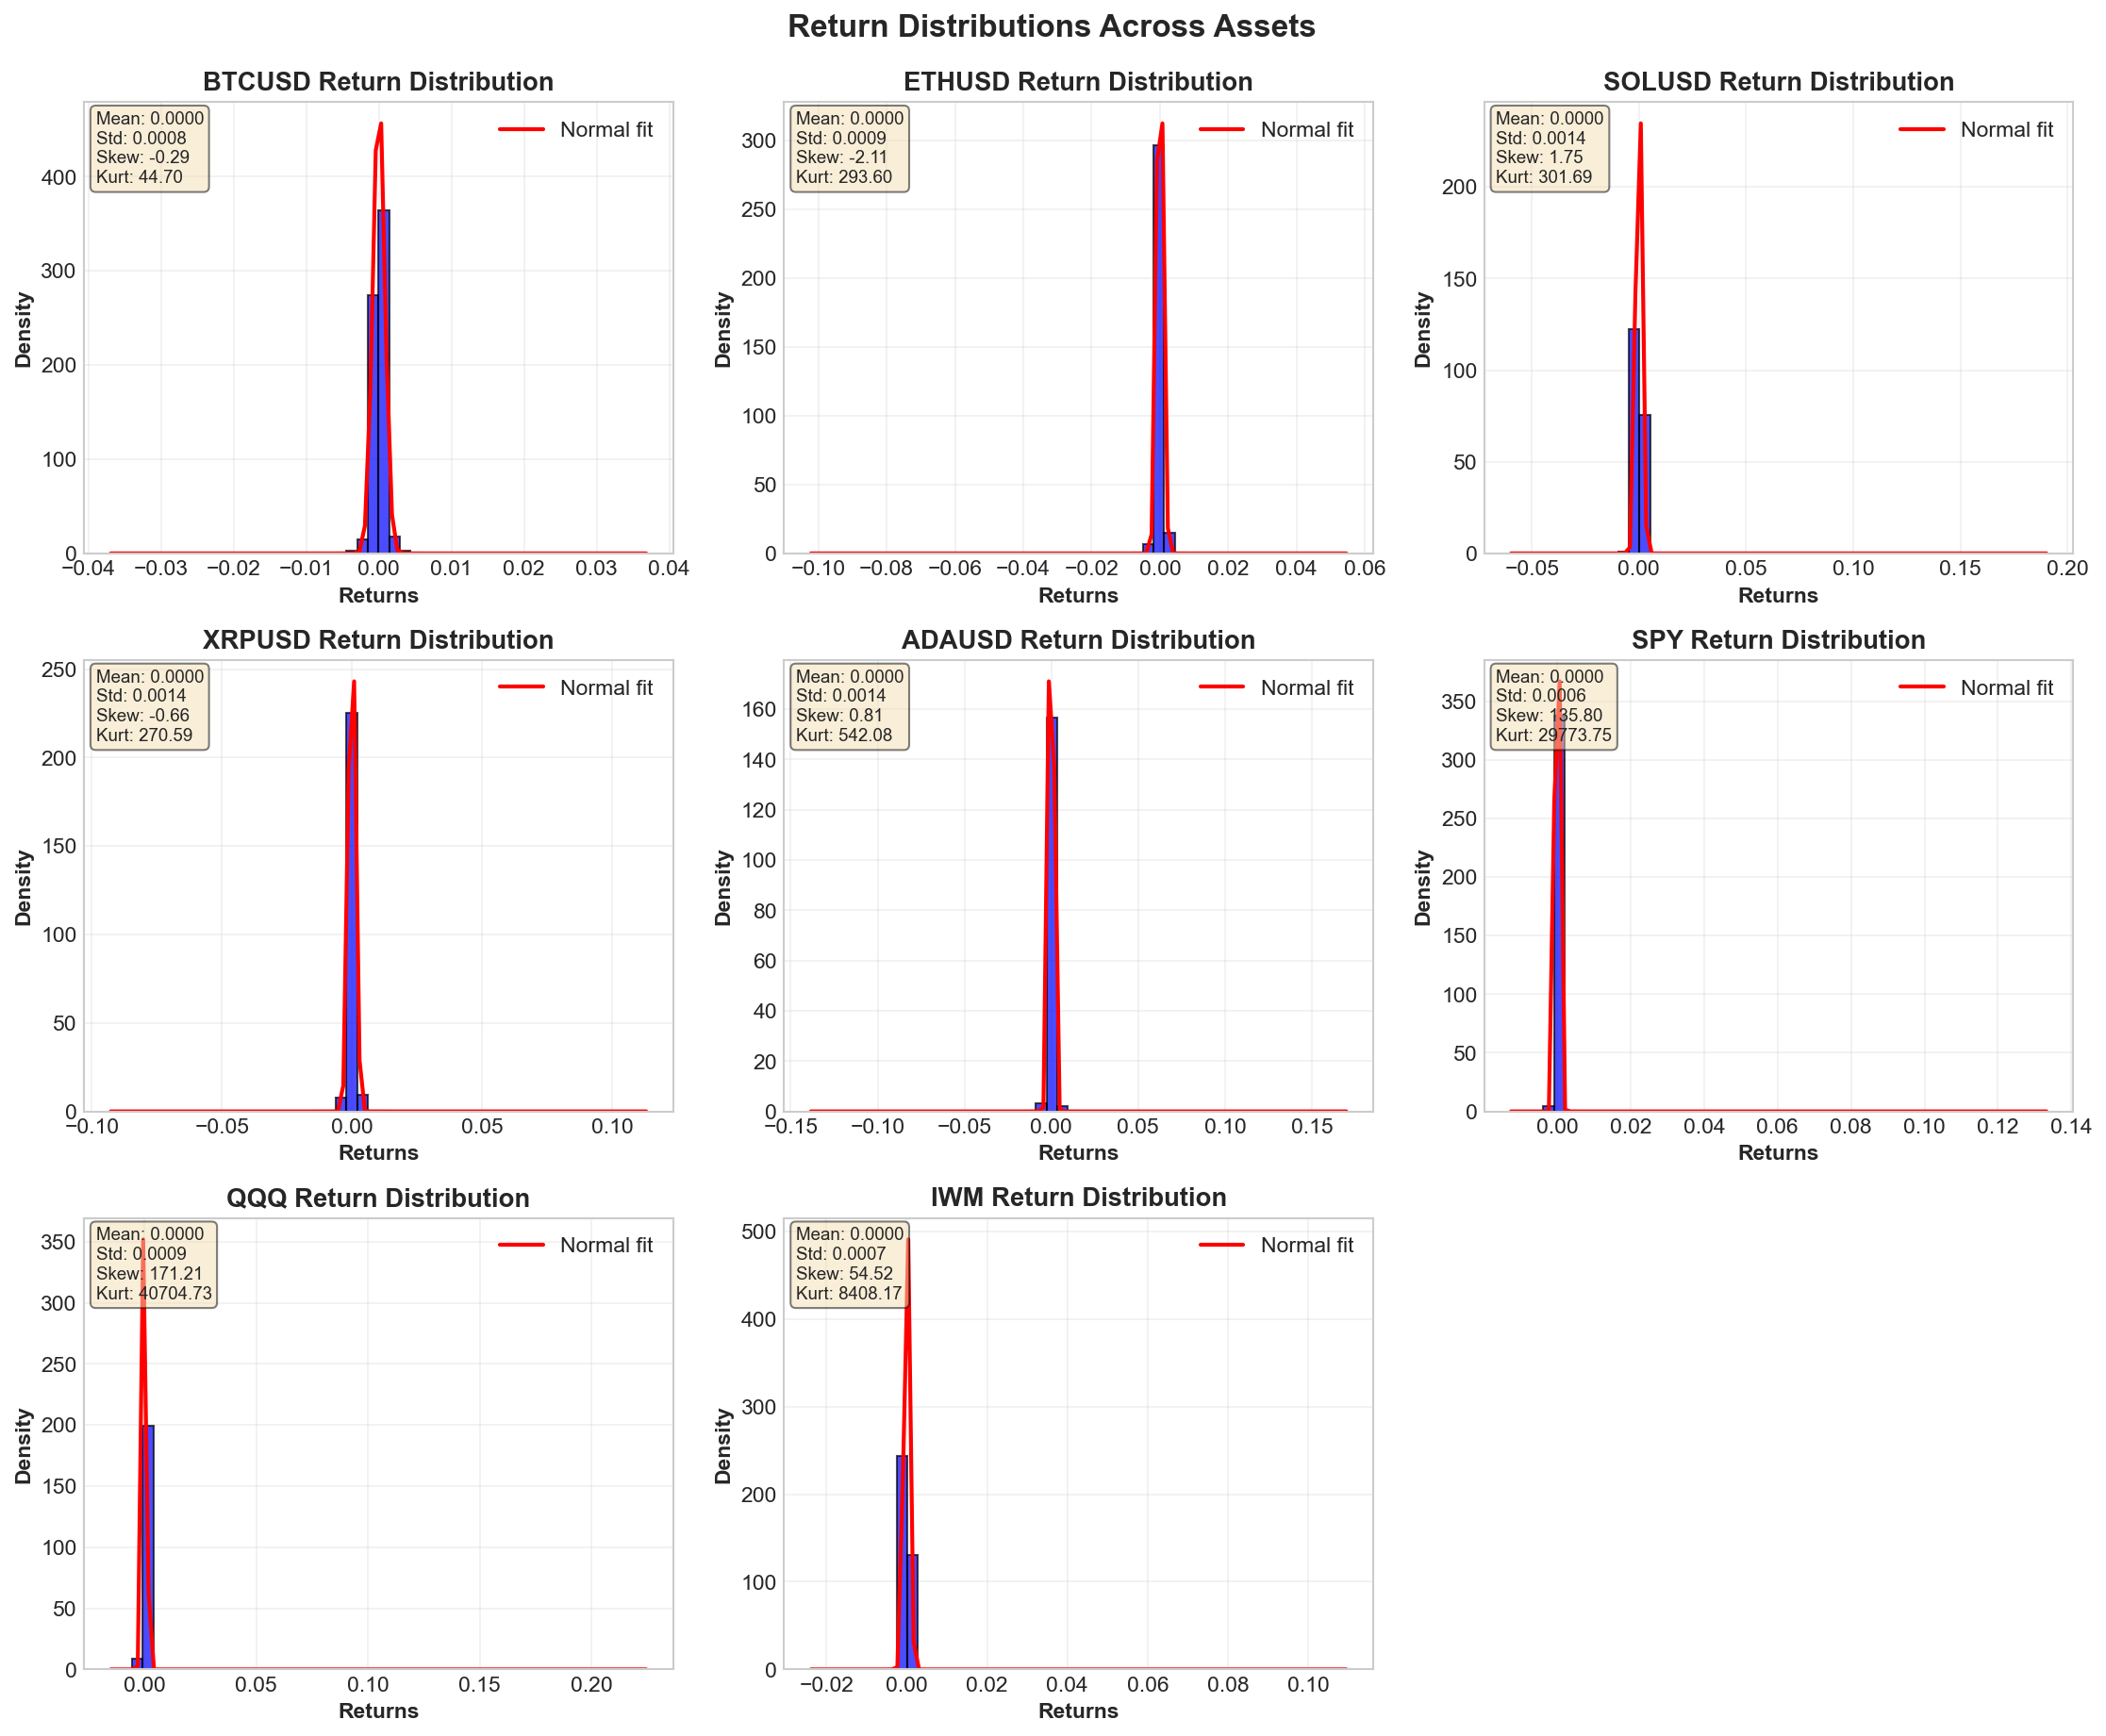


[OK] Distribution visualizations complete


In [5]:
# Visualize distributions for all available symbols
print("DISTRIBUTION VISUALIZATION")
print("="*80)

if all_symbols:
    n_symbols = len(all_symbols)
    n_cols = min(3, n_symbols)
    n_rows = (n_symbols + n_cols - 1) // n_cols
    
    # Print distribution statistics first
    print("\nDistribution Statistics Summary:")
    for symbol in all_symbols:
        if symbol in analysis_data:
            returns = analysis_data[symbol]['returns'].dropna()
            
            print(f"\n{symbol}:")
            print(f"  Count: {len(returns)}")
            print(f"  Mean: {returns.mean():.6f}")
            print(f"  Std: {returns.std():.6f}")
            print(f"  Skewness: {skew(returns):.3f}")
            print(f"  Kurtosis: {kurtosis(returns):.3f}")
            print(f"  Min: {returns.min():.6f}")
            print(f"  25%: {returns.quantile(0.25):.6f}")
            print(f"  50% (median): {returns.quantile(0.50):.6f}")
            print(f"  75%: {returns.quantile(0.75):.6f}")
            print(f"  Max: {returns.max():.6f}")
    
    # Create visualizations only if we have symbols
    if n_symbols > 0:
        try:
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
            if n_symbols == 1:
                axes = [axes]
            else:
                axes = axes.flatten() if n_rows > 1 else axes
            
            for idx, symbol in enumerate(all_symbols):
                if symbol in analysis_data:
                    ax = axes[idx]
                    returns = analysis_data[symbol]['returns'].dropna()
                    
                    # Plot histogram
                    n, bins, patches = ax.hist(returns, bins=50, density=True, alpha=0.7, 
                                               color='blue', edgecolor='black')
                    
                    # Fit normal distribution
                    mu, sigma = returns.mean(), returns.std()
                    x = np.linspace(returns.min(), returns.max(), 100)
                    ax.plot(x, norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
                    
                    # Add statistics
                    stats_text = f'Mean: {mu:.4f}\nStd: {sigma:.4f}\nSkew: {skew(returns):.2f}\nKurt: {kurtosis(returns):.2f}'
                    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                           fontsize=9, verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                    
                    ax.set_title(f'{symbol} Return Distribution', fontweight='bold')
                    ax.set_xlabel('Returns')
                    ax.set_ylabel('Density')
                    ax.legend()
                    ax.grid(True, alpha=0.3)
            
            # Remove empty subplots
            for idx in range(n_symbols, len(axes)):
                fig.delaxes(axes[idx])
            
            plt.tight_layout()
            plt.suptitle('Return Distributions Across Assets', fontsize=16, fontweight='bold', y=1.02)
            plt.show()
        except Exception as e:
            print(f"Could not create distribution plots: {e}")
else:
    print("No symbols available for distribution visualization")

### 5. Correlation Analysis

CORRELATION ANALYSIS
Building returns matrix...
  Added BTCUSD: 1359128 data points
  Added ETHUSD: 1358217 data points
  Added SOLUSD: 1354458 data points
  Added XRPUSD: 1311370 data points
  Added ADAUSD: 1347194 data points
  Added SPY: 77638 data points
  Added QQQ: 78492 data points
  Added IWM: 66381 data points

Returns matrix shape: (1359359, 8) -> (54954, 8) after removing NaN
Date range: 2023-01-03 09:01:00 to 2024-01-13 00:59:00
Common data points: 54954
Symbols in matrix: ['BTCUSD', 'ETHUSD', 'SOLUSD', 'XRPUSD', 'ADAUSD', 'SPY', 'QQQ', 'IWM']

Calculating correlation matrix...

Pearson Correlation Matrix:
        BTCUSD  ETHUSD  SOLUSD  XRPUSD  ADAUSD    SPY    QQQ    IWM
BTCUSD   1.000   0.749   0.642   0.472   0.606  0.197  0.163  0.220
ETHUSD   0.749   1.000   0.671   0.506   0.641  0.209  0.174  0.229
SOLUSD   0.642   0.671   1.000   0.480   0.623  0.194  0.162  0.213
XRPUSD   0.472   0.506   0.480   1.000   0.489  0.128  0.106  0.146
ADAUSD   0.606   0.641   0.623   0

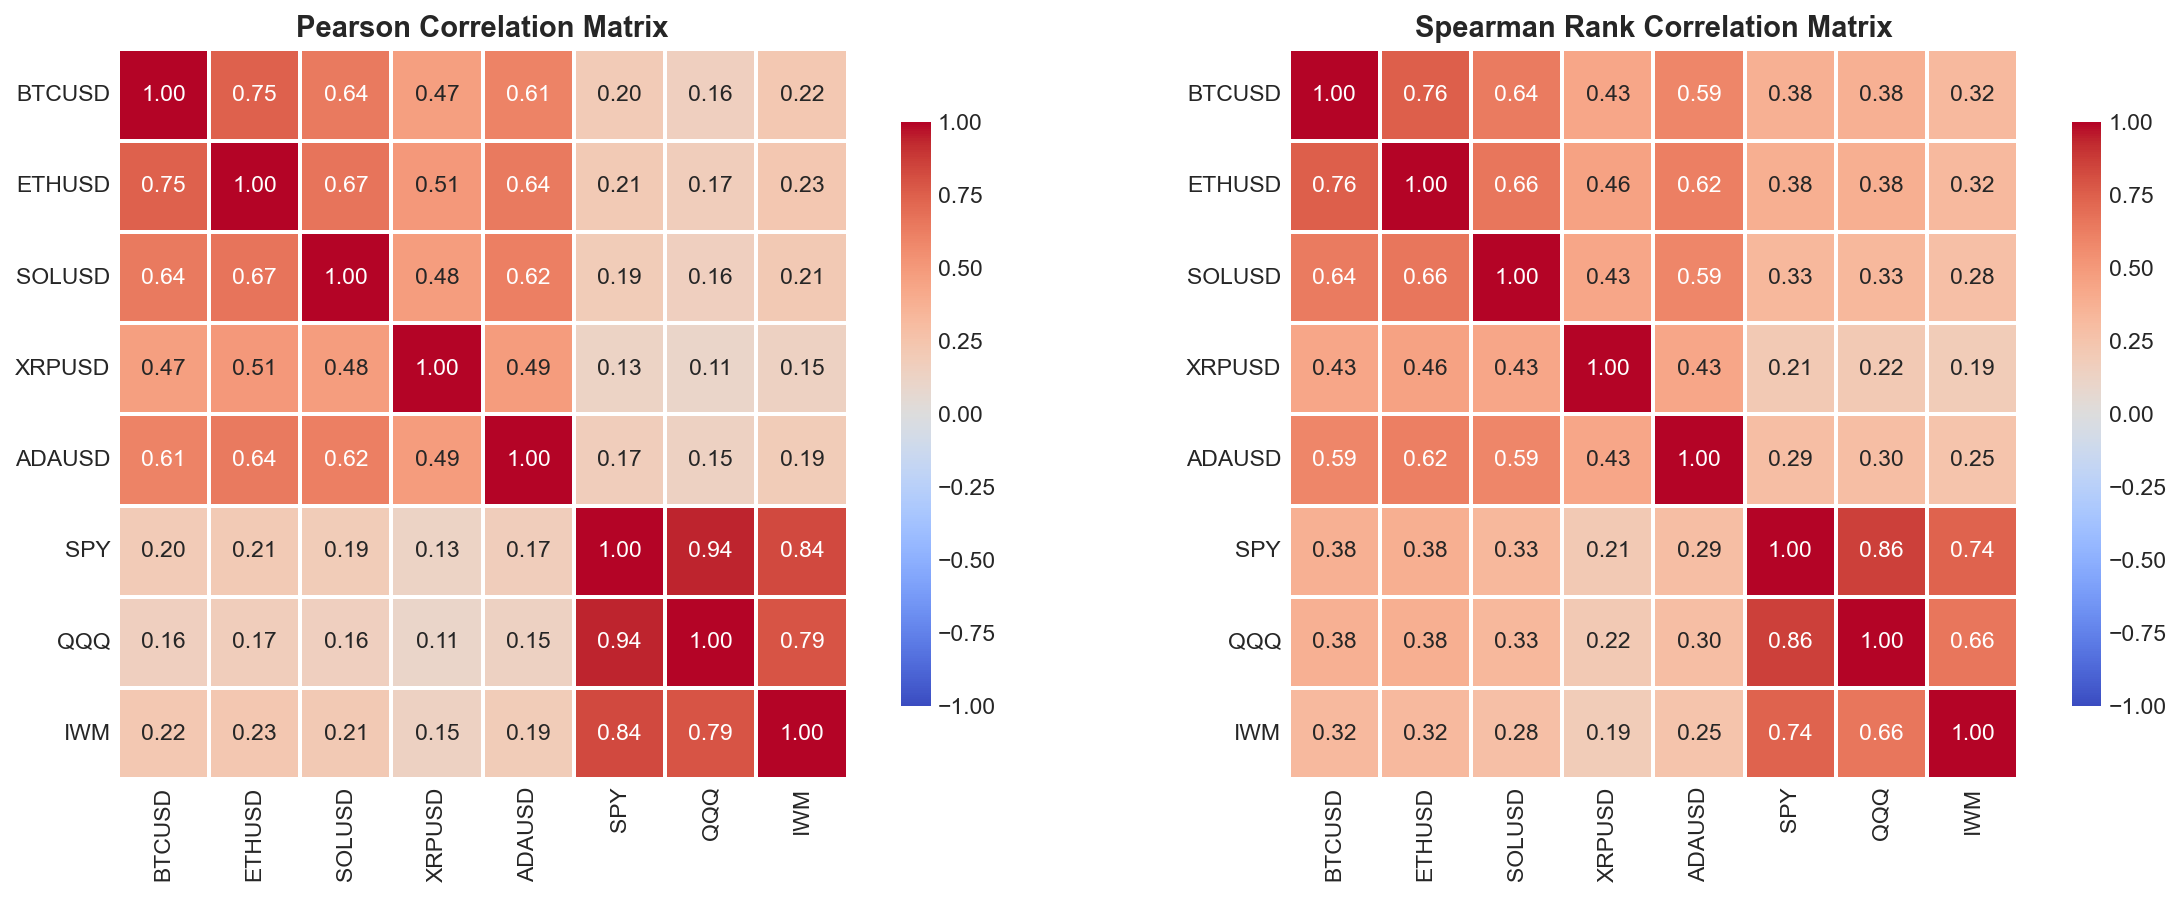


ROLLING CORRELATION ANALYSIS
Symbols: BTCUSD vs ETHUSD
Window: 720 hours (~30.0 days)

Rolling Correlation Statistics:
  Data points: 54775
  Mean:   0.7754
  Median: 0.8169
  Std:    0.1268
  Min:    0.1095
  Max:    0.9240
  Range:  0.8146

Sample correlation values (first 10):
  2023-01-03 14:25:00: 0.1095
  2023-01-03 14:27:00: 0.1095
  2023-01-03 14:28:00: 0.1102
  2023-01-03 14:30:00: 0.1165
  2023-01-03 14:31:00: 0.1168
  2023-01-03 14:32:00: 0.1254
  2023-01-03 14:33:00: 0.1289
  2023-01-03 14:34:00: 0.1356
  2023-01-03 14:35:00: 0.1340
  2023-01-03 14:36:00: 0.1469

Sample correlation values (last 10):
  2024-01-12 22:30:00: 0.7130
  2024-01-12 22:33:00: 0.7136
  2024-01-12 22:34:00: 0.7143
  2024-01-12 23:07:00: 0.7142
  2024-01-12 23:08:00: 0.7154
  2024-01-12 23:12:00: 0.7154
  2024-01-13 00:56:00: 0.7153
  2024-01-13 00:57:00: 0.7153
  2024-01-13 00:58:00: 0.7154
  2024-01-13 00:59:00: 0.7150

Correlation Stability Analysis:
  Periods with correlation > 0.7: 45170 (82.5%)

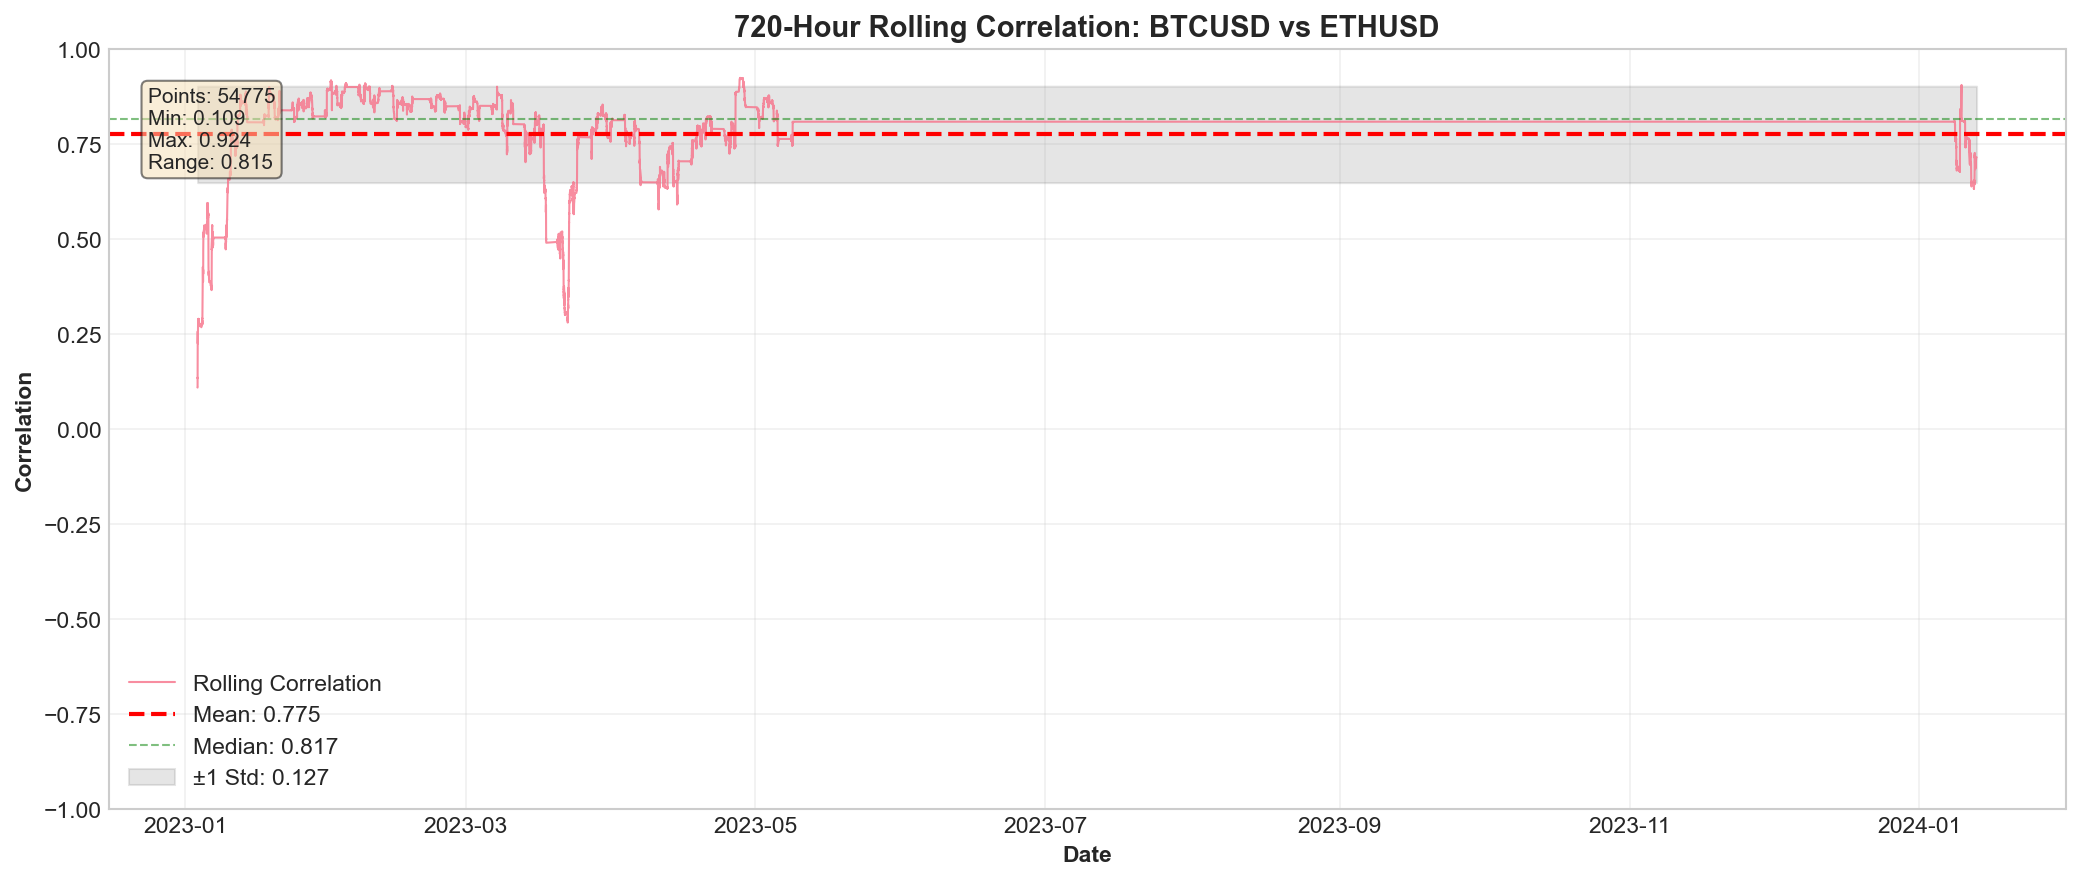


[OK] Correlation analysis complete


In [6]:
# Optimized Correlation Analysis with vectorization
print("CORRELATION ANALYSIS")
print("="*80)

print("Building returns matrix...")

# Get all returns data at once
returns_dict = {}
for symbol in all_symbols:
    if symbol in analysis_data:
        returns_dict[symbol] = analysis_data[symbol]['returns']
        print(f"  Added {symbol}: {len(analysis_data[symbol]['returns'])} data points")

if returns_dict:
    returns_matrix = pd.DataFrame(returns_dict)
    
    # Align all series to common dates (removes NaN)
    initial_shape = returns_matrix.shape
    returns_matrix = returns_matrix.dropna()
    final_shape = returns_matrix.shape
    
    print(f"\nReturns matrix shape: {initial_shape} -> {final_shape} after removing NaN")
    if len(returns_matrix) > 0:
        print(f"Date range: {returns_matrix.index.min()} to {returns_matrix.index.max()}")
        print(f"Common data points: {len(returns_matrix)}")
        print(f"Symbols in matrix: {list(returns_matrix.columns)}")
    else:
        print("WARNING: No common data points found across symbols!")
        returns_matrix = pd.DataFrame()
else:
    returns_matrix = pd.DataFrame()
    print("No returns data available")

if len(returns_matrix.columns) > 1 and len(returns_matrix) > 0:
    print("\nCalculating correlation matrix...")
    correlation_matrix = returns_matrix.corr(method='pearson')  # Pearson correlation coefficient
    
    spearman_corr = returns_matrix.corr(method='spearman')
    
    print("\nPearson Correlation Matrix:")
    print(correlation_matrix.round(3))
    
    print("\nSpearman Correlation Matrix:")
    print(spearman_corr.round(3))
    
    print("\nKey Correlations (Pearson):")
    for i, sym1 in enumerate(correlation_matrix.columns):
        for j, sym2 in enumerate(correlation_matrix.columns):
            if i < j:  # Only print upper triangle
                corr_val = correlation_matrix.loc[sym1, sym2]
                print(f"  {sym1} vs {sym2}: {corr_val:.3f}")
    
    try:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Pearson correlation
        sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    vmin=-1, vmax=1, square=True, linewidths=1,
                    cbar_kws={"shrink": 0.8}, ax=axes[0])
        axes[0].set_title('Pearson Correlation Matrix', fontsize=14, fontweight='bold')
        
        # Spearman correlation
        sns.heatmap(spearman_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                    vmin=-1, vmax=1, square=True, linewidths=1,
                    cbar_kws={"shrink": 0.8}, ax=axes[1])
        axes[1].set_title('Spearman Rank Correlation Matrix', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not create correlation heatmap: {e}")
else:
    correlation_matrix = pd.DataFrame()
    print("\nInsufficient data")

if len(returns_matrix.columns) >= 2 and len(returns_matrix) > 0:
    symbol1, symbol2 = returns_matrix.columns[0], returns_matrix.columns[1]
    window = min(30 * 24, len(returns_matrix) // 2)  # 30 days or half the data
    
    print(f"\n" + "="*80)
    print(f"ROLLING CORRELATION ANALYSIS")
    print(f"Symbols: {symbol1} vs {symbol2}")
    print(f"Window: {window} hours (~{window/24:.1f} days)")
    print("="*80)
    
    try:
        subset_data = returns_matrix[[symbol1, symbol2]]
        rolling_corr_series = subset_data[symbol1].rolling(
            window=window, min_periods=max(10, window//4)
        ).corr(subset_data[symbol2])
        
        rolling_corr_series = rolling_corr_series.dropna()
        
        if len(rolling_corr_series) > 0:
            # Calculate correlation stability metrics
            corr_mean = rolling_corr_series.mean()
            corr_std = rolling_corr_series.std()
            corr_min = rolling_corr_series.min()
            corr_max = rolling_corr_series.max()
            corr_median = rolling_corr_series.median()
            
            print(f"\nRolling Correlation Statistics:")
            print(f"  Data points: {len(rolling_corr_series)}")
            print(f"  Mean:   {corr_mean:.4f}")
            print(f"  Median: {corr_median:.4f}")
            print(f"  Std:    {corr_std:.4f}")
            print(f"  Min:    {corr_min:.4f}")
            print(f"  Max:    {corr_max:.4f}")
            print(f"Range:  {corr_max - corr_min:.4f}")
            
            print(f"\nSample correlation values (first 10):")
            for idx, (date, val) in enumerate(rolling_corr_series.head(10).items()):
                print(f"  {date}: {val:.4f}")
            
            print(f"\nSample correlation values (last 10):")
            for idx, (date, val) in enumerate(rolling_corr_series.tail(10).items()):
                print(f"  {date}: {val:.4f}")
            
            # Correlation stability analysis
            print(f"\nCorrelation Stability Analysis:")
            high_corr_periods = (rolling_corr_series > 0.7).sum()
            low_corr_periods = (rolling_corr_series < 0.3).sum()
            negative_corr_periods = (rolling_corr_series < 0).sum()
            
            print(f"Periods with correlation > 0.7: {high_corr_periods} ({high_corr_periods/len(rolling_corr_series)*100:.1f}%)")
            print(f"Periods with correlation < 0.3: {low_corr_periods} ({low_corr_periods/len(rolling_corr_series)*100:.1f}%)")
            print(f"Periods with negative correlation: {negative_corr_periods} ({negative_corr_periods/len(rolling_corr_series)*100:.1f}%)")
            
            try:
                plt.figure(figsize=(14, 6))
                plt.plot(rolling_corr_series.index, rolling_corr_series.values, 
                        linewidth=1, alpha=0.8, label='Rolling Correlation')
                plt.axhline(y=corr_mean, color='r', linestyle='--', 
                           label=f'Mean: {corr_mean:.3f}', linewidth=2)
                plt.axhline(y=corr_median, color='g', linestyle='--', 
                           label=f'Median: {corr_median:.3f}', linewidth=1, alpha=0.5)
                plt.fill_between(rolling_corr_series.index, 
                                 corr_mean - corr_std,
                                 corr_mean + corr_std,
                                 alpha=0.2, color='gray', label=f'±1 Std: {corr_std:.3f}')
                
                plt.title(f'{window}-Hour Rolling Correlation: {symbol1} vs {symbol2}', 
                         fontsize=14, fontweight='bold')
                plt.xlabel('Date')
                plt.ylabel('Correlation')
                plt.ylim(-1, 1)
                plt.legend(loc='best')
                plt.grid(True, alpha=0.3)
                
                # Add text box with statistics
                textstr = f'Points: {len(rolling_corr_series)}\nMin: {corr_min:.3f}\nMax: {corr_max:.3f}\nRange: {corr_max-corr_min:.3f}'
                plt.text(0.02, 0.95, textstr, transform=plt.gca().transAxes,
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Could not create rolling correlation plot: {e}")
                
        else:
            print("No valid rolling correlation data points")
            
    except Exception as e:
        print(f"Error calculating rolling correlation: {str(e)}")
        import traceback
        traceback.print_exc()

### 6. Volatility Analysis and GARCH Effects

VOLATILITY ANALYSIS
Calculating volatility metrics for 8 symbols...

[1/8] Processing BTCUSD... OK
[2/8] Processing ETHUSD... OK
[3/8] Processing SOLUSD... OK
[4/8] Processing XRPUSD... OK
[5/8] Processing ADAUSD... OK
[6/8] Processing SPY... OK
[7/8] Processing QQQ... OK
[8/8] Processing IWM... OK

Volatility Metrics Summary:
       daily_vol annualized_vol vol_of_vol max_drawdown realized_vol_30d  \
BTCUSD   0.00081       0.075781   0.000483     -0.33124         0.000717   
ETHUSD  0.000925       0.086596   0.000562    -0.661692         0.000814   
SOLUSD  0.001401       0.131101   0.000767    -0.675678         0.001265   
XRPUSD  0.001355       0.126818    0.00089    -0.587128         0.001128   
ADAUSD  0.001416       0.132569    0.00087    -0.656486         0.001213   
SPY     0.000608       0.056869   0.000522    -0.089485         0.000397   
QQQ     0.000944       0.088379   0.000851    -0.090068         0.000546   
IWM     0.000713       0.066738   0.000523    -0.158912        

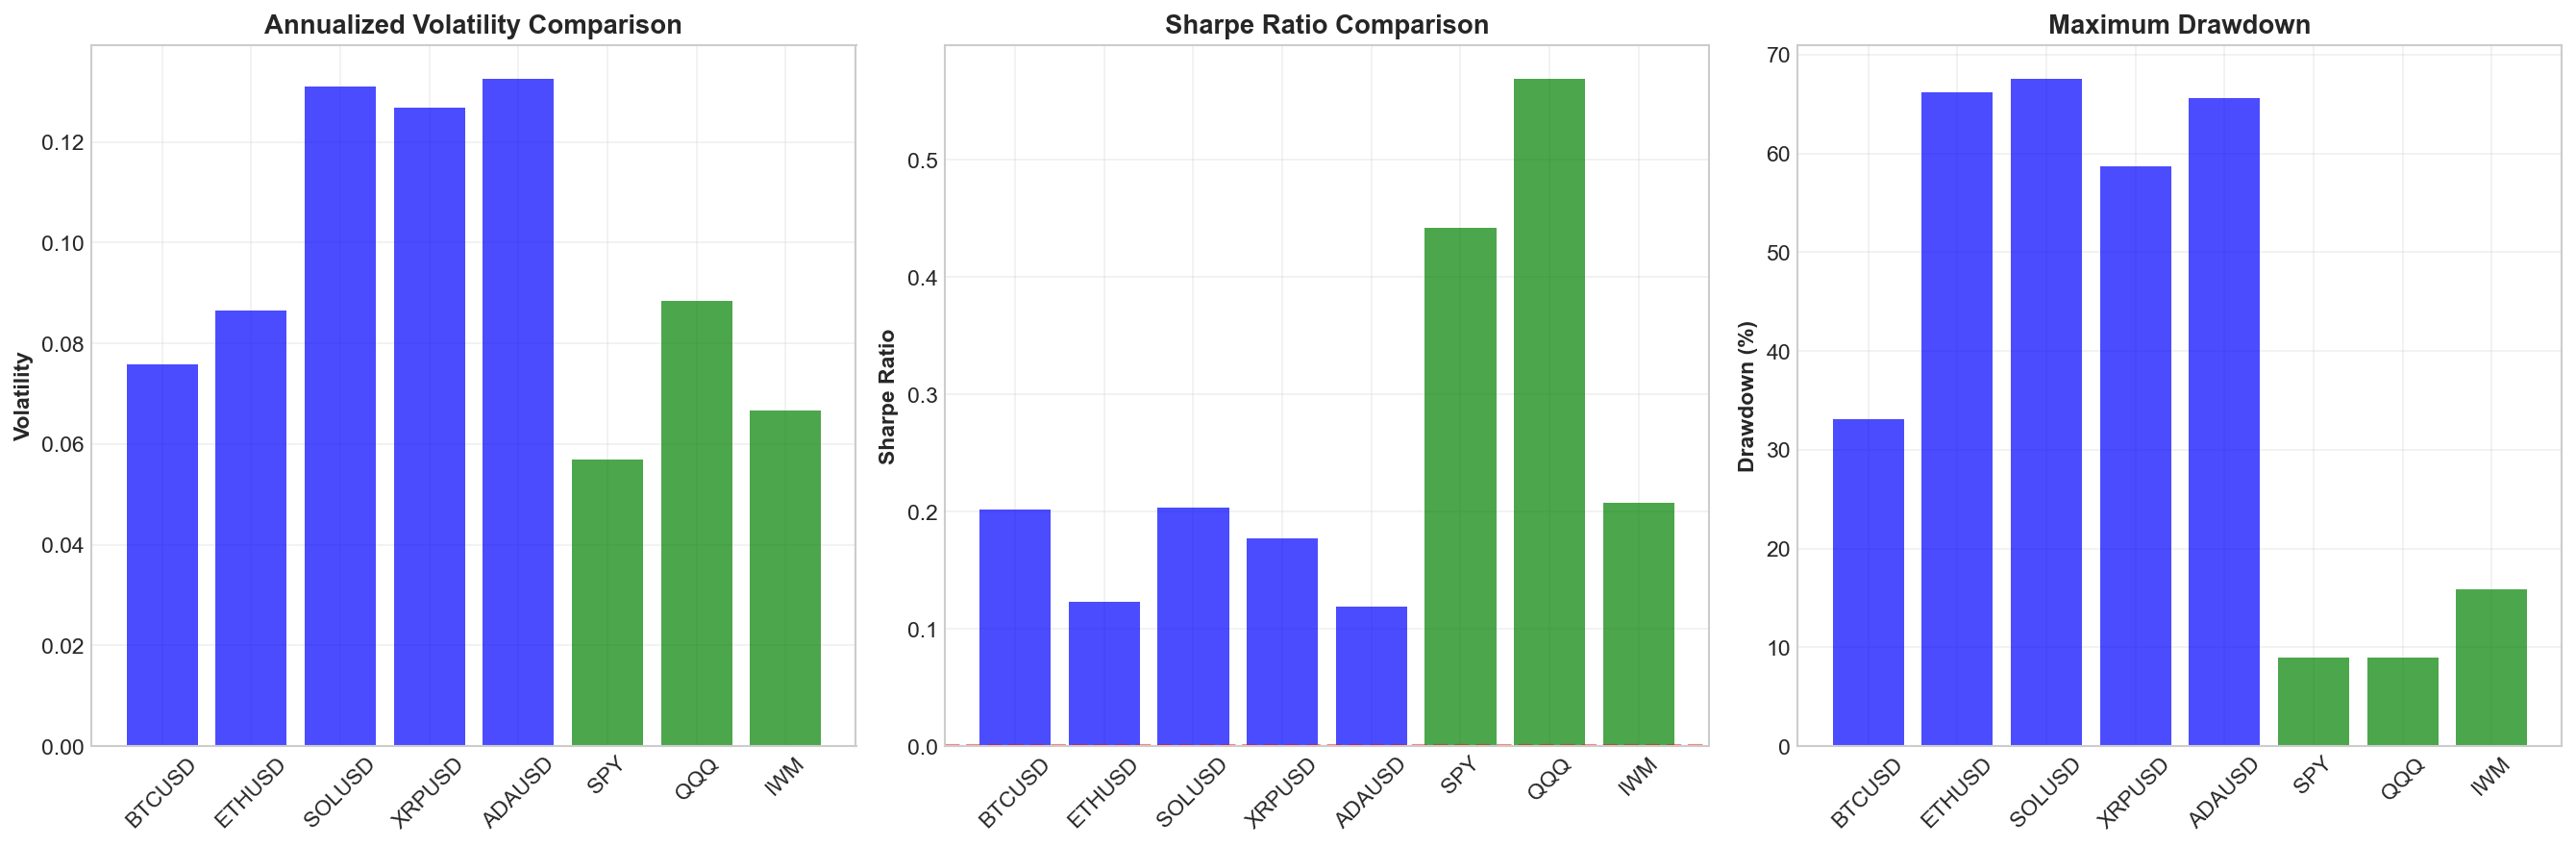

In [19]:
print("VOLATILITY ANALYSIS")
print("="*80)

def calculate_volatility_metrics(symbol, df):
    try:
        returns = df['returns'].dropna()
        
        # Basic volatility metrics
        daily_vol = returns.std()
        annualization_factor = np.sqrt(365 * 24)  # For hourly data
        
        metrics = {
            'daily_vol': daily_vol,
            'annualized_vol': daily_vol * annualization_factor,
            'vol_of_vol': returns.rolling(window=24).std().std(),
            'max_drawdown': (df['close'] / df['close'].cummax() - 1).min(),
            'realized_vol_30d': returns.rolling(window=24*30).std().mean() if len(returns) > 24*30 else np.nan,
            'realized_vol_7d': returns.rolling(window=24*7).std().mean() if len(returns) > 24*7 else np.nan,
            'sharpe_ratio': (returns.mean() / daily_vol) * annualization_factor if daily_vol > 0 else 0,
        }
        
        # GARCH test for volatility
        try:
            arch_test = het_arch(returns.values, nlags=10)
            metrics['arch_lm_stat'] = arch_test[0]
            metrics['arch_lm_pvalue'] = arch_test[1]
            metrics['has_volatility_clustering'] = arch_test[1] < 0.05
        except:
            metrics['arch_lm_stat'] = None
            metrics['arch_lm_pvalue'] = None
            metrics['has_volatility_clustering'] = None
        
        return symbol, metrics
    except Exception as e:
        print(f"Error calculating volatility for {symbol}: {str(e)}")
        return symbol, {}

print(f"Calculating volatility metrics for {len(all_symbols)} symbols...\n")

volatility_results = {}

for i, symbol in enumerate(all_symbols, 1):
    if symbol in analysis_data:
        print(f"[{i}/{len(all_symbols)}] Processing {symbol}...", end=' ')
        sym, metrics = calculate_volatility_metrics(symbol, analysis_data[symbol])
        if metrics:
            volatility_results[sym] = metrics
            print("OK")
        else:
            print("FAIL")

if volatility_results:
    vol_df = pd.DataFrame(volatility_results).T
    
    print("\nVolatility Metrics Summary:")
    print("="*80)
    print(vol_df.round(4))
    
    # Statistical comparison between asset classes
    if len(available_crypto) > 0 and len(available_equity) > 0:
        crypto_vols = [volatility_results[s]['annualized_vol'] for s in available_crypto 
                      if s in volatility_results and 'annualized_vol' in volatility_results[s]]
        equity_vols = [volatility_results[s]['annualized_vol'] for s in available_equity 
                      if s in volatility_results and 'annualized_vol' in volatility_results[s]]
        
        if crypto_vols and equity_vols:
            crypto_vol = np.mean(crypto_vols)
            equity_vol = np.mean(equity_vols)
            
            print(f"\nVolatility Comparison:")
            print(f"  Crypto avg annualized vol: {crypto_vol:.2%}")
            print(f"  Equity avg annualized vol: {equity_vol:.2%}")
            print(f"  Ratio (Crypto/Equity): {crypto_vol/equity_vol:.2f}x")

    if len(volatility_results) > 1:
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # 1. Annualized volatility comparison
        ax = axes[0]
        symbols = list(volatility_results.keys())
        vols = [volatility_results[s].get('annualized_vol', 0) for s in symbols]
        colors = ['blue' if s in available_crypto else 'green' for s in symbols]
        bars = ax.bar(range(len(symbols)), vols, color=colors, alpha=0.7)
        ax.set_xticks(range(len(symbols)))
        ax.set_xticklabels(symbols, rotation=45)
        ax.set_title('Annualized Volatility Comparison', fontweight='bold')
        ax.set_ylabel('Volatility')
        ax.grid(True, alpha=0.3)
        
        # 2. Sharpe ratio comparison
        ax = axes[1]
        sharpes = [volatility_results[s].get('sharpe_ratio', 0) for s in symbols]
        bars = ax.bar(range(len(symbols)), sharpes, color=colors, alpha=0.7)
        ax.set_xticks(range(len(symbols)))
        ax.set_xticklabels(symbols, rotation=45)
        ax.set_title('Sharpe Ratio Comparison', fontweight='bold')
        ax.set_ylabel('Sharpe Ratio')
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)
        ax.grid(True, alpha=0.3)
        
        # 3. Max drawdown
        ax = axes[2]
        drawdowns = [abs(volatility_results[s].get('max_drawdown', 0)) * 100 for s in symbols]
        bars = ax.bar(range(len(symbols)), drawdowns, color=colors, alpha=0.7)
        ax.set_xticks(range(len(symbols)))
        ax.set_xticklabels(symbols, rotation=45)
        ax.set_title('Maximum Drawdown', fontweight='bold')
        ax.set_ylabel('Drawdown (%)')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 7. Market Microstructure Analysis

In [18]:
def analyze_microstructure(data, symbol):
    try:
        results = {}
        returns = data['returns'].dropna()
        acf_1 = returns.autocorr(lag=1)
        acf_5 = returns.autocorr(lag=5)
        acf_10 = returns.autocorr(lag=10)
        
        try:
            lb_result = acorr_ljungbox(returns, lags=10, return_df=True)
            lb_stat = lb_result['lb_stat'].iloc[-1]
            lb_pval = lb_result['lb_pvalue'].iloc[-1]
        except:
            lb_stat, lb_pval = None, None
        
        if 'volume' in data.columns:
            volume = data['volume'].dropna()
            volume_cv = volume.std() / volume.mean() if volume.mean() > 0 else None
            volume_autocorr = volume.autocorr(lag=1)
            price_volume_corr = data['returns'].abs().corr(data['volume'])
        else:
            volume_cv = None
            volume_autocorr = None
            price_volume_corr = None
        
        if 'high' in data.columns and 'low' in data.columns:
            hl_ratio = np.log(data['high'] / data['low'])
            beta = hl_ratio**2
            gamma = (np.log(data['high'] / data['low'].shift(1)))**2
            alpha = (np.sqrt(2*beta) - np.sqrt(beta)) / (3 - 2*np.sqrt(2)) - np.sqrt(gamma / (3 - 2*np.sqrt(2)))
            spread_cs = 2 * (np.exp(alpha) - 1) / (1 + np.exp(alpha))
            avg_spread = spread_cs.mean()
            spread_vol = spread_cs.std()
        else:
            avg_spread = None
            spread_vol = None
        
        if 'volume' in data.columns:
            dollar_volume = data['volume'] * data['close']
            amihud = (returns.abs() / (dollar_volume + 1e-10)).mean()
        else:
            amihud = None
        
        results = {
            'symbol': symbol,
            'autocorrelation': {
                'lag_1': acf_1,
                'lag_5': acf_5,
                'lag_10': acf_10
            },
            'ljung_box': {
                'statistic': lb_stat,
                'p_value': lb_pval,
                'has_serial_correlation': lb_pval < 0.05 if lb_pval else None
            },
            'volume': {
                'coefficient_variation': volume_cv,
                'autocorrelation': volume_autocorr,
                'price_volume_corr': price_volume_corr
            },
            'liquidity': {
                'avg_spread_cs': avg_spread,
                'spread_volatility': spread_vol,
                'amihud_illiquidity': amihud
            }
        }
        
        return results
    except Exception as e:
        print(f"Error in microstructure analysis for {symbol}: {str(e)}")
        return None

print("MARKET MICROSTRUCTURE")
print("="*80)

print(f"Analyzing microstructure for {len(all_symbols)} symbols...\n")

microstructure_results = {}

for i, symbol in enumerate(all_symbols, 1):
    if symbol in analysis_data:
        print(f"[{i}/{len(all_symbols)}] Processing {symbol}...", end=' ')
        result = analyze_microstructure(analysis_data[symbol], symbol)
        if result:
            microstructure_results[symbol] = result
            print("Pass")
        else:
            print("Fail")

for symbol in all_symbols:
    if symbol in microstructure_results:
        micro_stats = microstructure_results[symbol]
        
        print(f"\n{symbol}:")
        print(f"Autocorrelation:")
        if micro_stats['autocorrelation']['lag_1'] is not None:
            print(f"Lag 1: {micro_stats['autocorrelation']['lag_1']:.4f}")
        if micro_stats['autocorrelation']['lag_5'] is not None:
            print(f"Lag 5: {micro_stats['autocorrelation']['lag_5']:.4f}")
        if micro_stats['autocorrelation']['lag_10'] is not None:
            print(f"Lag 10: {micro_stats['autocorrelation']['lag_10']:.4f}")
        
        if micro_stats['ljung_box']['p_value'] is not None:
            print(f"Ljung-Box test:")
            print(f"p-value: {micro_stats['ljung_box']['p_value']:.4f}")
            print(f"Serial correlation: {'Yes' if micro_stats['ljung_box']['has_serial_correlation'] else 'No'}")
        
        if micro_stats['volume']['coefficient_variation'] is not None:
            print(f"Volume patterns:")
            print(f"Coefficient of variation: {micro_stats['volume']['coefficient_variation']:.4f}")
            if micro_stats['volume']['autocorrelation'] is not None:
                print(f"Volume autocorrelation: {micro_stats['volume']['autocorrelation']:.4f}")
            if micro_stats['volume']['price_volume_corr'] is not None:
                print(f"|Return|-Volume correlation: {micro_stats['volume']['price_volume_corr']:.4f}")
        
        if micro_stats['liquidity']['avg_spread_cs'] is not None:
            print(f"  Liquidity metrics:")
            print(f"    Avg Corwin-Schultz spread: {micro_stats['liquidity']['avg_spread_cs']:.6f}")
            if micro_stats['liquidity']['spread_volatility'] is not None:
                print(f"    Spread volatility: {micro_stats['liquidity']['spread_volatility']:.6f}")
        
        if micro_stats['liquidity']['amihud_illiquidity'] is not None:
            print(f"    Amihud illiquidity: {micro_stats['liquidity']['amihud_illiquidity']:.2e}")

MARKET MICROSTRUCTURE
Analyzing microstructure for 8 symbols...

[1/8] Processing BTCUSD... Pass
[2/8] Processing ETHUSD... Pass
[3/8] Processing SOLUSD... Pass
[4/8] Processing XRPUSD... Pass
[5/8] Processing ADAUSD... Pass
[6/8] Processing SPY... Pass
[7/8] Processing QQQ... Pass
[8/8] Processing IWM... Pass

BTCUSD:
Autocorrelation:
Lag 1: -0.1626
Lag 5: -0.0005
Lag 10: 0.0015
Ljung-Box test:
p-value: 0.0000
Serial correlation: No
Volume patterns:
Coefficient of variation: 2.0875
Volume autocorrelation: 0.6114
|Return|-Volume correlation: 0.4484
  Liquidity metrics:
    Avg Corwin-Schultz spread: -0.000004
    Spread volatility: 0.001615
    Amihud illiquidity: 8.99e-09

ETHUSD:
Autocorrelation:
Lag 1: -0.0844
Lag 5: -0.0031
Lag 10: 0.0010
Ljung-Box test:
p-value: 0.0000
Serial correlation: No
Volume patterns:
Coefficient of variation: 2.1441
Volume autocorrelation: 0.5558
|Return|-Volume correlation: 0.5021
  Liquidity metrics:
    Avg Corwin-Schultz spread: -0.000005
    Spread vo

### 8. Hurst & Long Memory

In [21]:
def calculate_hurst_exponent(time_series, max_lag=100):
    try:
        ts = np.asarray(time_series)
        lags = range(2, min(max_lag, len(ts) // 2))
        tau = []
        for lag in lags:
            diff = ts[lag:] - ts[:-lag]
            tau_val = np.sqrt(np.std(diff))
            tau.append(float(tau_val))
        lags_array = np.array(list(lags))
        tau_array = np.array(tau)
        valid_mask = (tau_array > 0) & np.isfinite(tau_array)
        if valid_mask.sum() < 2:
            return np.nan
        poly = np.polyfit(np.log(lags_array[valid_mask]), np.log(tau_array[valid_mask]), 1)
        hurst = poly[0] * 2.0
        return hurst
    except Exception as e:
        print(f"Error calculating Hurst exponent: {str(e)}")
        return np.nan

def calculate_hurst_for_symbol(symbol, df):
    try:
        results = {}
        
        # Calculate for prices
        price_series = df['close'].values
        results['price'] = calculate_hurst_exponent(price_series)
        
        # Calculate for returns
        returns_series = df['returns'].dropna().values
        results['returns'] = calculate_hurst_exponent(returns_series)
        
        # Calculate for volume if available
        if 'volume' in df.columns:
            volume_series = df['volume'].values
            results['volume'] = calculate_hurst_exponent(volume_series)
        else:
            results['volume'] = None
        
        return symbol, results
    except Exception as e:
        print(f"Error processing {symbol}: {str(e)}")
        return symbol, {}

hurst_results = {}

for i, symbol in enumerate(all_symbols, 1):
    if symbol in analysis_data:
        print(f"[{i}/{len(all_symbols)}] Computing Hurst exponent for {symbol}...", end=' ')
        sym, hurst_values = calculate_hurst_for_symbol(symbol, analysis_data[symbol])
        if hurst_values:
            hurst_results[sym] = hurst_values
            print("Pass")
        else:
            print("Error")

# Display results with interpretation
print("\nResults:")
print("="*80)

for symbol in all_symbols:
    if symbol in hurst_results:
        h = hurst_results[symbol]
        print(f"\n{symbol}:")
        
        # Price series
        if h.get('price') is not None and not np.isnan(h['price']):
            interpretation = 'Trending' if h['price'] > 0.55 else 'Mean-reverting' if h['price'] < 0.45 else 'Random walk'
            print(f"  Price series: H = {h['price']:.3f} [{interpretation}]")
        
        # Returns
        if h.get('returns') is not None and not np.isnan(h['returns']):
            interpretation = 'Trending' if h['returns'] > 0.55 else 'Mean-reverting' if h['returns'] < 0.45 else 'Random walk'
            print(f"  Returns:      H = {h['returns']:.3f} [{interpretation}]")
        
        # Volume
        if h.get('volume') is not None and not np.isnan(h['volume']):
            interpretation = 'Trending' if h['volume'] > 0.55 else 'Mean-reverting' if h['volume'] < 0.45 else 'Random walk'
            print(f"  Volume:       H = {h['volume']:.3f} [{interpretation}]")

if len(available_crypto) > 0 and len(available_equity) > 0:
    crypto_hurst_returns = [hurst_results[s]['returns'] for s in available_crypto 
                           if s in hurst_results and hurst_results[s].get('returns') is not None 
                           and not np.isnan(hurst_results[s]['returns'])]
    equity_hurst_returns = [hurst_results[s]['returns'] for s in available_equity 
                           if s in hurst_results and hurst_results[s].get('returns') is not None 
                           and not np.isnan(hurst_results[s]['returns'])]
    
    if crypto_hurst_returns and equity_hurst_returns:
        print(f"\nHurst Exponent Comparison (Returns):")
        print(f"  Crypto average: {np.mean(crypto_hurst_returns):.3f}")
        print(f"  Equity average: {np.mean(equity_hurst_returns):.3f}")
        print(f"  Difference: {np.mean(crypto_hurst_returns) - np.mean(equity_hurst_returns):.3f}")

print("\nHurst exponent analysis complete")

[1/8] Computing Hurst exponent for BTCUSD... Pass
[2/8] Computing Hurst exponent for ETHUSD... Pass
[3/8] Computing Hurst exponent for SOLUSD... Pass
[4/8] Computing Hurst exponent for XRPUSD... Pass
[5/8] Computing Hurst exponent for ADAUSD... Pass
[6/8] Computing Hurst exponent for SPY... Pass
[7/8] Computing Hurst exponent for QQQ... Pass
[8/8] Computing Hurst exponent for IWM... Pass

Results:

BTCUSD:
  Price series: H = 0.477 [Random walk]
  Returns:      H = -0.000 [Mean-reverting]
  Volume:       H = 0.057 [Mean-reverting]

ETHUSD:
  Price series: H = 0.490 [Random walk]
  Returns:      H = -0.000 [Mean-reverting]
  Volume:       H = 0.047 [Mean-reverting]

SOLUSD:
  Price series: H = 0.484 [Random walk]
  Returns:      H = -0.000 [Mean-reverting]
  Volume:       H = 0.039 [Mean-reverting]

XRPUSD:
  Price series: H = 0.480 [Random walk]
  Returns:      H = -0.001 [Mean-reverting]
  Volume:       H = 0.059 [Mean-reverting]

ADAUSD:
  Price series: H = 0.487 [Random walk]
  Retu

### 9. Regime Detection and Analysis


REGIME ANALYSIS FOR BTCUSD

Statistics:
               returns                       volume
                  mean       std   count       mean
regime                                             
Bear_HighVol -0.000061  0.001085  328388  16.515578
Bear_LowVol  -0.000030  0.000433  327009   5.891170
Bull_HighVol  0.000062  0.001029  351092  16.560892
Bull_LowVol   0.000030  0.000441  352472   6.374267
Undefined     0.000002  0.000565     167  14.953849


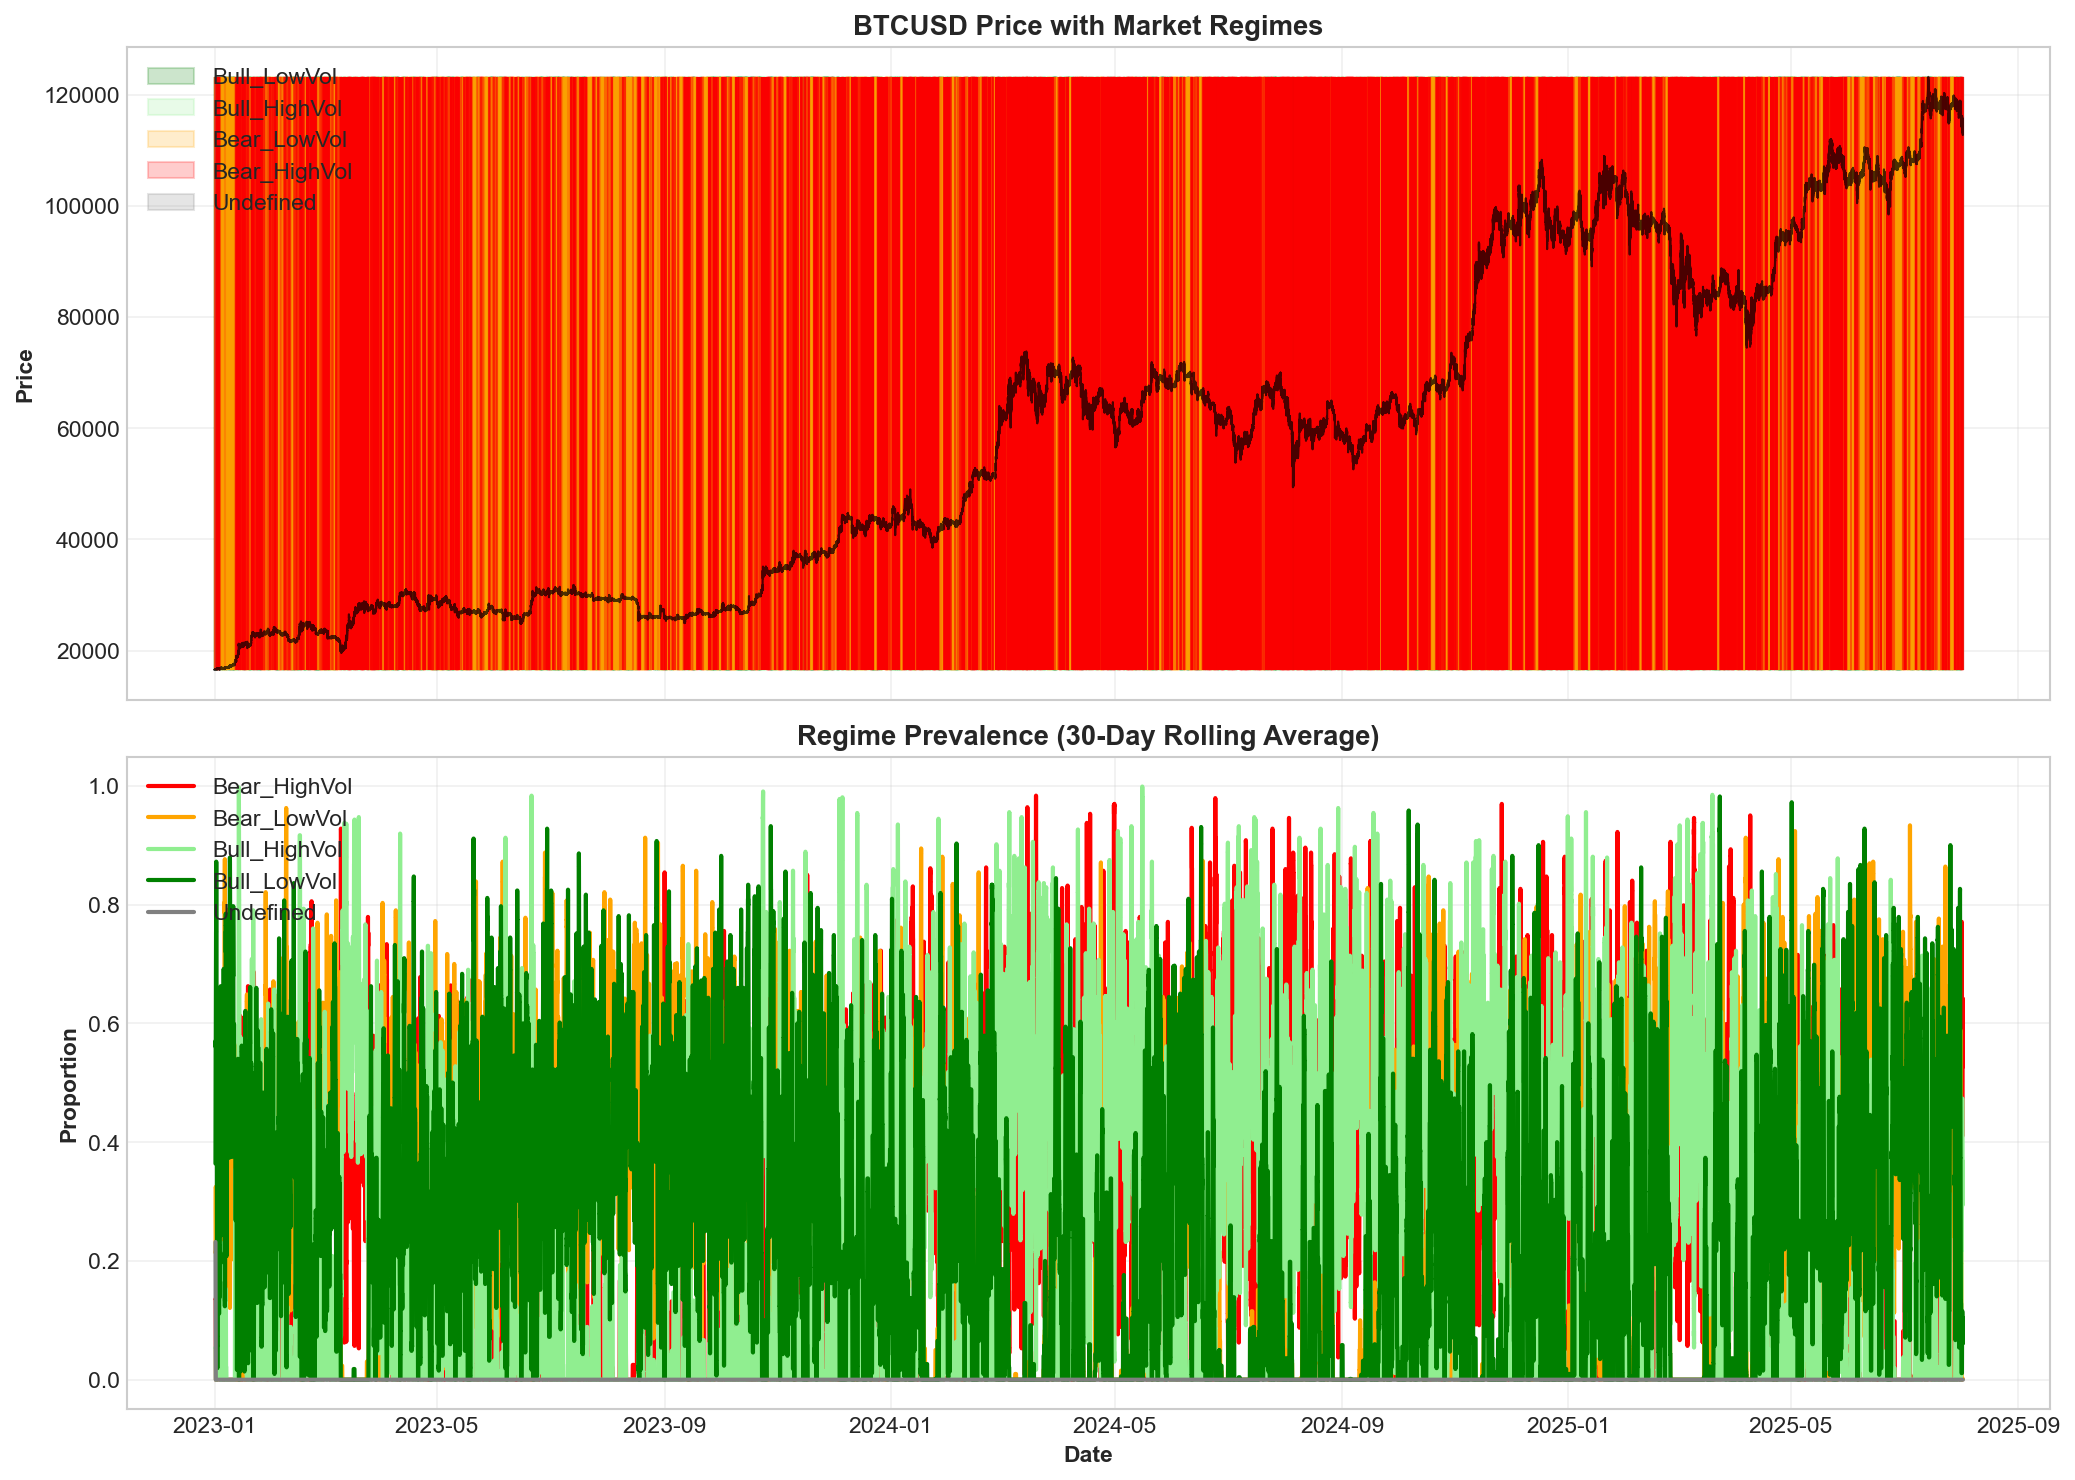

In [22]:
def identify_market_regimes(data, symbol):
    df = data.copy()
    window = 24 * 7
    df['rolling_vol'] = df['returns'].rolling(window=window).std()
    df['rolling_mean'] = df['returns'].rolling(window=window).mean()
    vol_median = df['rolling_vol'].median()
    conditions = [
        (df['rolling_mean'] > 0) & (df['rolling_vol'] <= vol_median), 
        (df['rolling_mean'] > 0) & (df['rolling_vol'] > vol_median),
        (df['rolling_mean'] <= 0) & (df['rolling_vol'] <= vol_median),
        (df['rolling_mean'] <= 0) & (df['rolling_vol'] > vol_median),
    ]
    choices = ['Bull_LowVol', 'Bull_HighVol', 'Bear_LowVol', 'Bear_HighVol']
    df['regime'] = pd.Series(
        np.select(conditions, choices, default='Undefined'),
        index=df.index
    )
    regime_stats = df.groupby('regime').agg({
        'returns': ['mean', 'std', 'count'],
        'volume': 'mean' if 'volume' in df.columns else lambda x: None
    })
    return df, regime_stats

if len(all_symbols) > 0:
    symbol = all_symbols[0]
    if symbol in analysis_data:
        print(f"\n" + "="*80)
        print(f"REGIME ANALYSIS FOR {symbol}")        
        regime_data, regime_stats = identify_market_regimes(analysis_data[symbol], symbol)
        
        print("\nStatistics:")
        print(regime_stats)
        # Visualize regimes
        fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
        
        ax = axes[0]
        regime_colors = {
            'Bull_LowVol': 'green',
            'Bull_HighVol': 'lightgreen',
            'Bear_LowVol': 'orange',
            'Bear_HighVol': 'red',
            'Undefined': 'gray'
        }
        
        ax.plot(regime_data.index, regime_data['close'], linewidth=1, color='black', alpha=0.7)
        
        for regime, color in regime_colors.items():
            mask = regime_data['regime'] == regime
            if mask.any():
                ax.fill_between(regime_data.index, 
                               regime_data['close'].min(), 
                               regime_data['close'].max(),
                               where=mask, alpha=0.2, color=color, label=regime)
        
        ax.set_title(f'{symbol} Price with Market Regimes', fontweight='bold')
        ax.set_ylabel('Price')
        ax.legend(loc='upper left')
        ax.grid(True, alpha=0.3)
        
        # Regime distribution over time
        ax = axes[1]
        regime_dummies = pd.get_dummies(regime_data['regime'])
        regime_cumsum = regime_dummies.rolling(window=24*30).mean()  # 30-day average
        
        for col in regime_cumsum.columns:
            if col in regime_colors:
                ax.plot(regime_cumsum.index, regime_cumsum[col], 
                       label=col, color=regime_colors[col], linewidth=2)
        
        ax.set_title('Regime Prevalence (30-Day Rolling Average)', fontweight='bold')
        ax.set_ylabel('Proportion')
        ax.set_xlabel('Date')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

## 10. Anomaly Detection

ANOMALY DETECTION - BTCUSD

Total anomalies detected: 13586 (1.00%)

Return Statistics Comparison:
             Normal     Anomalous
count  1.345542e+06  13586.000000
mean   1.060392e-06      0.000069
std    6.670888e-04      0.004637
min   -3.650029e-03     -0.036938
25%   -2.822343e-04     -0.003795
50%    0.000000e+00      0.002209
75%    2.849229e-04      0.003779
max    3.584933e-03      0.036828


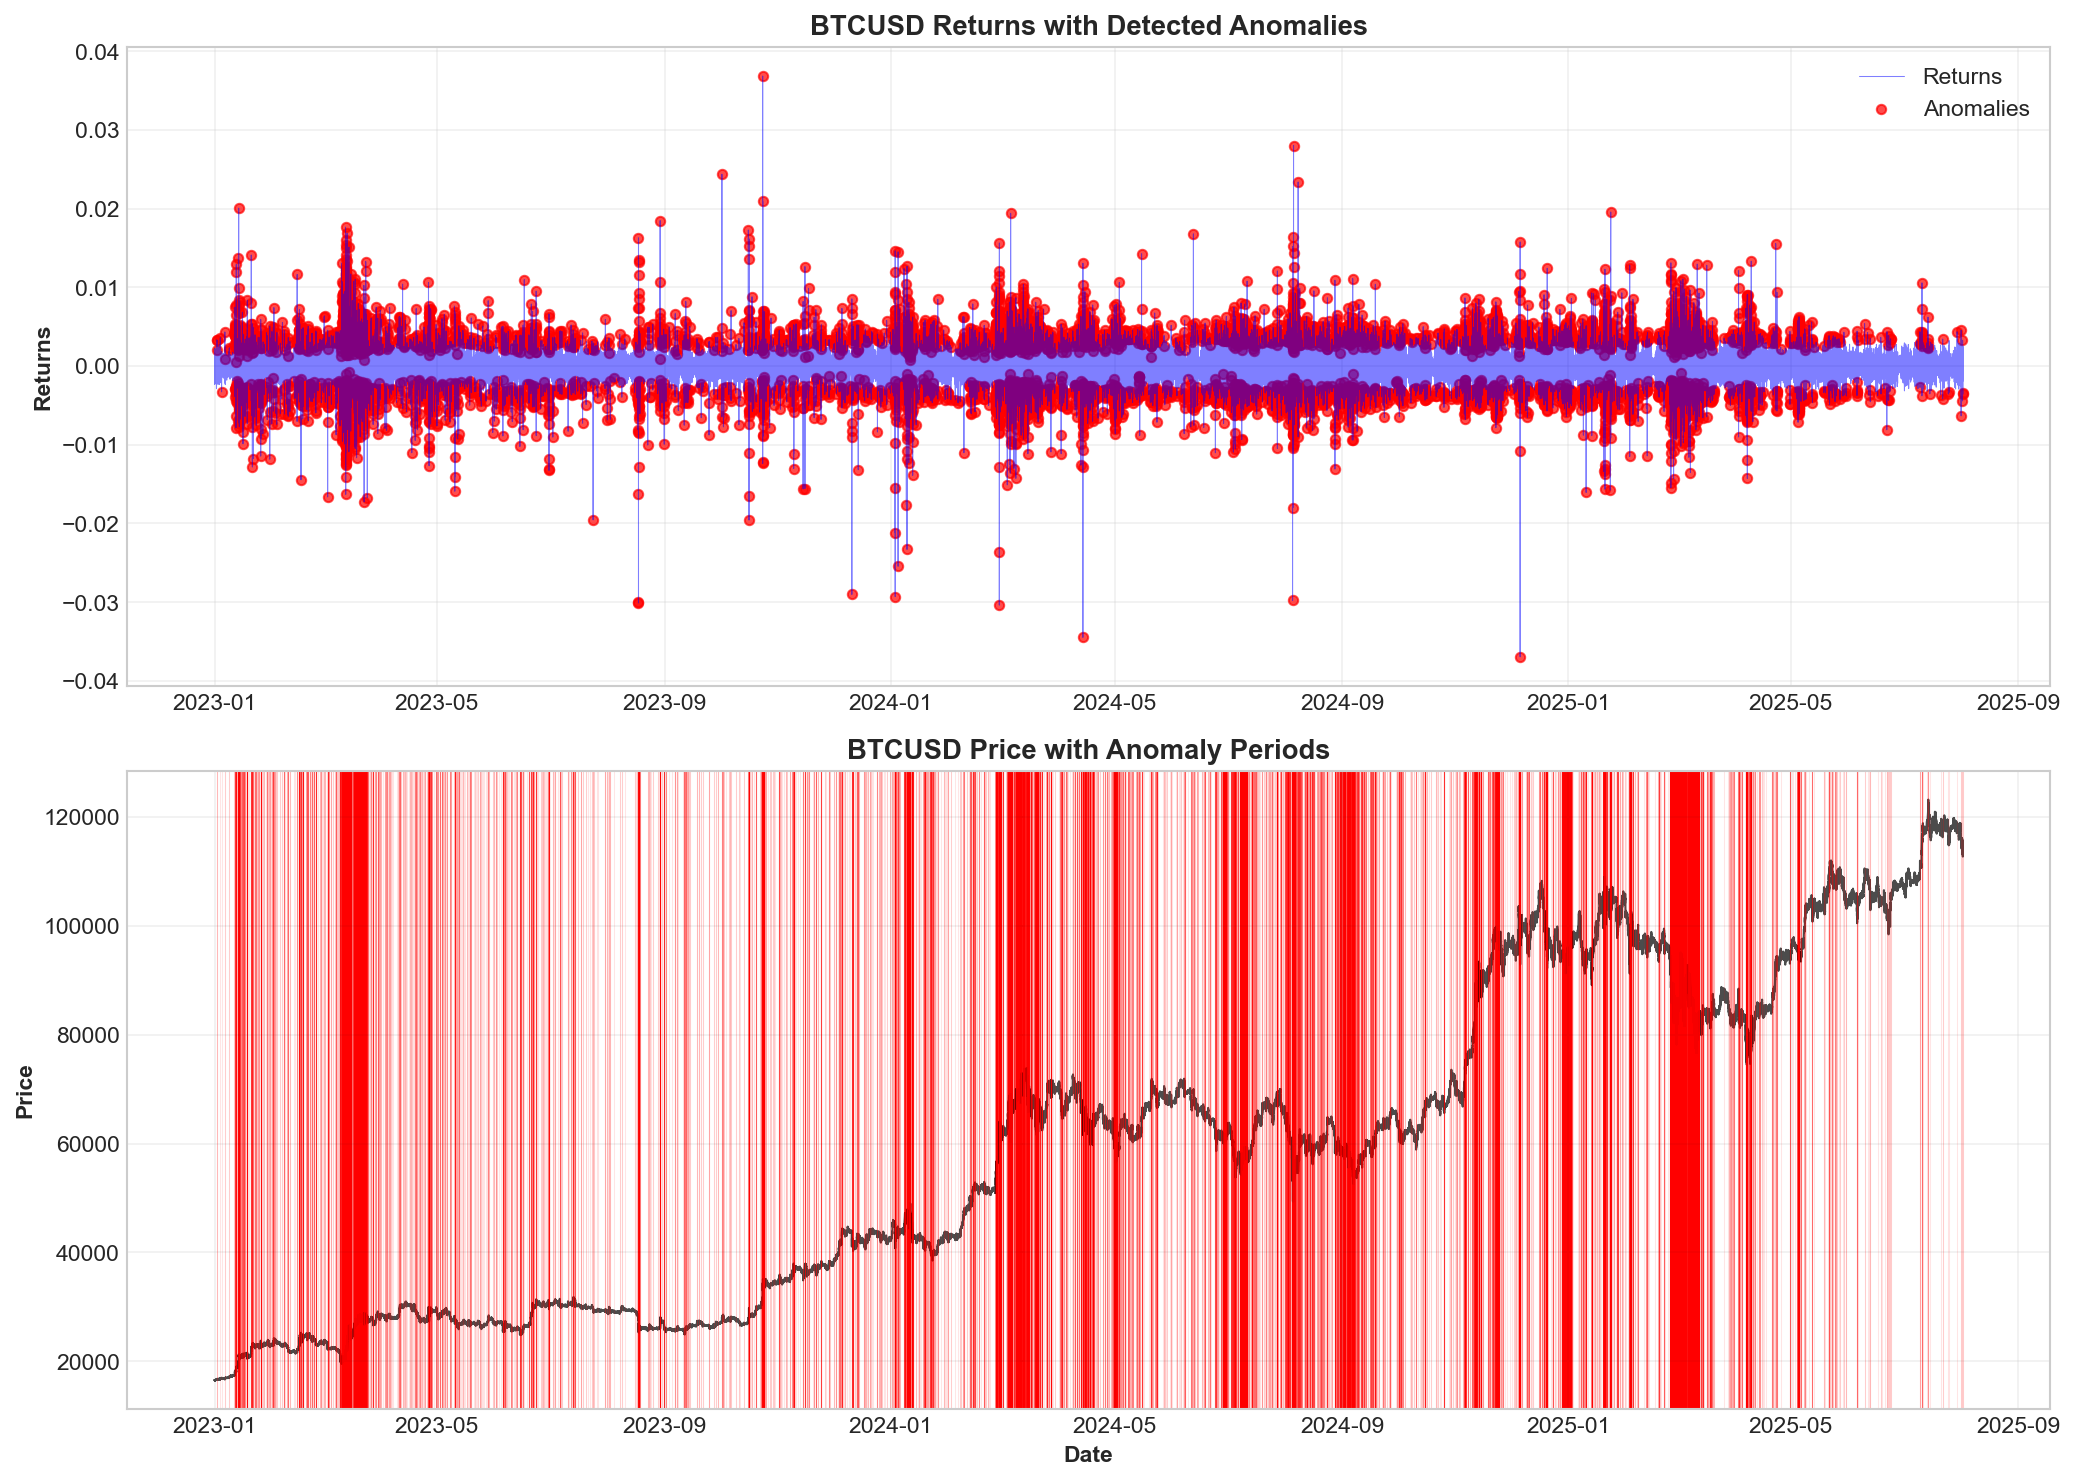


Anomaly detection complete


In [23]:
def detect_anomalies(data, symbol, contamination=0.01):    
    features = ['returns', 'volume'] if 'volume' in data.columns else ['returns']
    # Add technical features
    df = data.copy()
    df['returns_abs'] = df['returns'].abs()
    df['returns_squared'] = df['returns'] ** 2
    if 'high' in df.columns and 'low' in df.columns:
        df['high_low_ratio'] = df['high'] / df['low']
        features.extend(['high_low_ratio'])
    features.extend(['returns_abs', 'returns_squared'])
    # Prepare data
    X = df[features].dropna()
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomalies = iso_forest.fit_predict(X)
    # Add anomaly labels back to dataframe
    df.loc[X.index, 'anomaly'] = anomalies
    df['is_anomaly'] = df['anomaly'] == -1
    return df

if len(all_symbols) > 0:
    symbol = all_symbols[0]
    if symbol in analysis_data:
        print(f"ANOMALY DETECTION - {symbol}")
        print("="*80)
        anomaly_data = detect_anomalies(analysis_data[symbol], symbol)
        n_anomalies = anomaly_data['is_anomaly'].sum()
        pct_anomalies = n_anomalies / len(anomaly_data) * 100
        print(f"\nTotal anomalies detected: {n_anomalies} ({pct_anomalies:.2f}%)")
        normal_stats = anomaly_data[~anomaly_data['is_anomaly']]['returns'].describe()
        anomaly_stats = anomaly_data[anomaly_data['is_anomaly']]['returns'].describe()
        comparison = pd.DataFrame({
            'Normal': normal_stats,
            'Anomalous': anomaly_stats
        })
        print("\nReturn Statistics Comparison:")
        print(comparison)
        # Visualize anomalies
        fig, axes = plt.subplots(2, 1, figsize=(14, 10))
        ax = axes[0]
        ax.plot(anomaly_data.index, anomaly_data['returns'], 
               linewidth=0.5, color='blue', alpha=0.5, label='Returns')
        
        # Highlight anomalies
        anomaly_points = anomaly_data[anomaly_data['is_anomaly']]
        ax.scatter(anomaly_points.index, anomaly_points['returns'], 
                  color='red', s=20, alpha=0.7, label='Anomalies')
        
        ax.set_title(f'{symbol} Returns with Detected Anomalies', fontweight='bold')
        ax.set_ylabel('Returns')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Price with anomalies
        ax = axes[1]
        ax.plot(anomaly_data.index, anomaly_data['close'], 
               linewidth=1, color='black', alpha=0.7)
        # Mark anomaly periods
        for idx in anomaly_points.index:
            ax.axvline(x=idx, color='red', alpha=0.1, linewidth=0.5)
        ax.set_title(f'{symbol} Price with Anomaly Periods', fontweight='bold')
        ax.set_ylabel('Price')
        ax.set_xlabel('Date')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        print("\nAnomaly detection complete")

### 11. Feature Importance from Models

In [ ]:
Not Implemented

## 12. Comprehensive Summary Statistics

In [26]:
# Create comprehensive summary
summary_stats = {}

print("COMPREHENSIVE STATISTICAL SUMMARY")

for symbol in all_symbols:
    if symbol in analysis_data:
        df = analysis_data[symbol]
        returns = df['returns'].dropna()
        
        # Calculate comprehensive statistics
        summary_stats[symbol] = {
            # Basic statistics
            'count': len(returns),
            'mean_return': returns.mean(),
            'median_return': returns.median(),
            'std_return': returns.std(),
            
            # Risk metrics
            'sharpe_ratio': returns.mean() / returns.std() * np.sqrt(365 * 24) if returns.std() > 0 else 0,
            'sortino_ratio': returns.mean() / returns[returns < 0].std() * np.sqrt(365 * 24) if len(returns[returns < 0]) > 0 else 0,
            'max_drawdown': (df['close'] / df['close'].cummax() - 1).min(),
            'var_95': np.percentile(returns, 5),
            'cvar_95': returns[returns <= np.percentile(returns, 5)].mean(),
            
            # Higher moments
            'skewness': skew(returns),
            'kurtosis': kurtosis(returns),
            'jarque_bera_pval': jarque_bera(returns)[1],
            
            # Market structure
            'hurst_exponent': hurst_results.get(symbol, {}).get('returns', None) if 'hurst_results' in locals() else None,
            'autocorr_lag1': returns.autocorr(lag=1),
            
            # Volatility
            'annualized_vol': returns.std() * np.sqrt(365 * 24),
            'vol_of_vol': returns.rolling(window=24).std().std(),
        }

# Create summary DataFrame
summary_df = pd.DataFrame(summary_stats).T

# Display key metrics
print("\nKey Risk-Adjusted Performance Metrics:")
print(summary_df[['sharpe_ratio', 'sortino_ratio', 'max_drawdown', 'annualized_vol']].round(4))

print("\nDistribution Characteristics:")
print(summary_df[['skewness', 'kurtosis', 'jarque_bera_pval']].round(4))

print("\nMarket Microstructure:")
if 'hurst_exponent' in summary_df.columns:
    print(summary_df[['hurst_exponent', 'autocorr_lag1']].round(4))
else:
    print(summary_df[['autocorr_lag1']].round(4))

if len(available_crypto) > 0 and len(available_equity) > 0:
    print("\n" + "="*80)
    print("CRYPTO vs EQUITY COMPARISON")
    print("="*80)
    
    crypto_stats = summary_df.loc[available_crypto].mean()
    equity_stats = summary_df.loc[available_equity].mean() if len(available_equity) > 0 else pd.Series()
    
    if len(equity_stats) > 0:
        comparison = pd.DataFrame({
            'Crypto (Avg)': crypto_stats,
            'Equity (Avg)': equity_stats,
            'Difference': crypto_stats - equity_stats
        })
        
        print(comparison.round(4))
    else:
        print("\n[INFO] No equity data available for comparison")
        print("\nCrypto Statistics (Average):")
        print(crypto_stats.round(4))

COMPREHENSIVE STATISTICAL SUMMARY

Key Risk-Adjusted Performance Metrics:
        sharpe_ratio  sortino_ratio  max_drawdown  annualized_vol
BTCUSD        0.2016         0.2487       -0.3312          0.0758
ETHUSD        0.1231         0.1508       -0.6617          0.0866
SOLUSD        0.2032         0.2679       -0.6757          0.1311
XRPUSD        0.1775         0.2103       -0.5871          0.1268
ADAUSD        0.1186         0.1464       -0.6565          0.1326
SPY           0.4422         0.8906       -0.0895          0.0569
QQQ           0.5693         1.3164       -0.0901          0.0884
IWM           0.2079         0.3292       -0.1589          0.0667

Distribution Characteristics:
        skewness    kurtosis  jarque_bera_pval
BTCUSD   -0.2911     44.6983               0.0
ETHUSD   -2.1143    293.5962               0.0
SOLUSD    1.7546    301.6893               0.0
XRPUSD   -0.6628    270.5865               0.0
ADAUSD    0.8059    542.0845               0.0
SPY     135.7958  2

##### Save Results for Next Notebook

In [25]:
results_to_save = {
    'analysis_timestamp': datetime.now().isoformat(),
    'symbols_analyzed': all_symbols,
    'crypto_symbols': available_crypto,
    'equity_symbols': available_equity,
    'analysis_data': analysis_data,
    'distribution_results': distribution_results,
    'correlation_matrix': correlation_matrix if 'correlation_matrix' in locals() else None,
    'volatility_results': volatility_results if 'volatility_results' in locals() else None,
    'microstructure_results': microstructure_results if 'microstructure_results' in locals() else None,
    'hurst_results': hurst_results if 'hurst_results' in locals() else None,
    'summary_statistics': summary_df if 'summary_df' in locals() else None,
    'engineered_data': engineered_data,
    'model_results': model_results,
    'config': config
}

# Save to pickle file
output_file = 'notebooks/02_statistical_results.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(results_to_save, f)